In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN

from tensorflow.keras import Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:
MID_LIST = []

def normalize(X):
    for column in X.columns:
        mid = (X[column].max() + X[column].min()) / 2
        X[column] = (X[column] - mid)  / (X[column].max() - mid)
        MID_LIST.append(mid)

def create_graph_list(X):
    
    graph = []
    
    columns = X.columns.tolist()
    
    # ,['cviec','pxuong']
    relation_ship = [['cviec1','tgian1'],['cviec2','tgian2'],['tuoinghe','A9a','A9b','nampx'],
                      ['hutthuoc','slthuoc'],['tiensuhh','benhhh'],['ho','tdho','tsho'],
                      ['khacdom','loaidom','tdkhacdo'],['khotho','mdkhotho','tdkhotho'],
                      ['daunguc','vitridau','daulan','tcdau','tgdau','ytodau'],
                      ['sutcan','socansut','tgsut'],['fvclt','fev1lt']]
    
    for tmp_i in range(len(relation_ship)):
        for tmp_j in range(len(relation_ship[tmp_i])):
            relation_ship[tmp_i][tmp_j] = columns.index(relation_ship[tmp_i][tmp_j])
    
    for i in tqdm(range(X.shape[0])):
        source = []
        target = []
        value = []
        indexing = []
        
        for j in range (0, X.shape[1]):
            if not np.isnan(X.iloc[i][j]):
                source.append(0)
                target.append(j)
                value.append(X.iloc[i][j])
                indexing.append(j)   
                
        for j in range(len(relation_ship)):
            flg = True
            for xx in relation_ship[j]:
                if np.isnan(X.iloc[i][xx]):
                    flg = False
                    break
            if flg:
                for xx in relation_ship[j]:
                    source.append(relation_ship[j][0])
                    target.append(xx) 
                
        sg_tmp = pd.DataFrame(
            {"source": source, "target": target}
        )
        sg_tmp_data = pd.DataFrame(
            {"value": value}, 
             index = indexing
        )
        
        sg = StellarGraph(sg_tmp_data, sg_tmp)
        graph.append(sg)
        
    return graph

In [3]:
df = pd.read_excel("Main_data_fixed_ver08.xlsx");

In [4]:
X, Y = df.iloc[:, :-1], df.iloc[:, -1]   

normalize(X)

In [13]:
X

,id,tinh,hoten,gioitinh,namsinh,sdt,cviec,pxuong,tuoinghe,nampx,...,F11,F12,F13,fvclt,fvctt,fev1lt,fev1tt,fvc,fev1,gaenler
0,-1.000000,0.0,0.579503,-1.0,0.259259,-0.831991,-0.016004,-0.968116,-0.714286,-0.714286,...,1.0,-1.0,1.0,0.560976,0.285714,0.487179,0.116279,-0.138566,0.003236,-0.129032
1,-0.999795,0.0,0.420301,1.0,0.000000,-0.867280,-0.446567,-0.127536,-0.632653,-0.632653,...,1.0,-0.6,1.0,-0.463415,-0.523810,-0.435897,-0.581395,-0.103144,0.003236,-0.138850
2,-0.999590,0.0,0.763739,-1.0,0.259259,-0.986575,0.586990,-0.820290,-0.469388,-0.551020,...,-1.0,NaN,NaN,0.121951,0.000000,0.128205,0.023256,-0.064997,0.237170,0.043643
3,-0.999384,0.0,0.633874,-1.0,0.370370,0.080936,0.754259,0.055072,-0.673469,-0.673469,...,1.0,0.4,1.0,0.414634,0.190476,0.384615,0.116279,-0.117313,0.092233,-0.045840
4,-0.999179,0.0,0.980833,-1.0,0.481481,-0.423475,0.165720,-0.031884,-0.795918,-0.795918,...,1.0,0.4,1.0,0.121951,0.142857,0.128205,0.069767,0.082141,0.298197,-0.049695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8025,0.999179,0.5,0.681205,-1.0,0.111111,0.576908,-0.270005,-0.086957,-0.714286,-0.714286,...,-1.0,NaN,NaN,-0.365854,-0.523810,-0.435897,-0.581395,-0.215517,0.003236,-0.138850
8026,0.999384,0.5,0.020536,-1.0,0.629630,0.503644,-0.499226,-0.617391,-0.836735,-0.836735,...,-1.0,NaN,NaN,0.073171,-0.142857,0.025641,-0.255814,-0.172124,-0.029126,-0.136316
8027,0.999590,0.5,0.520438,-1.0,0.370370,NaN,-0.499226,-0.617391,-0.551020,-0.551020,...,1.0,-0.7,1.0,0.268293,0.142857,0.128205,0.023256,-0.047481,0.237170,-0.098518
8028,0.999795,0.5,0.450812,-1.0,0.000000,NaN,-0.765617,-0.802899,-0.918367,-0.918367,...,1.0,-0.6,1.0,-0.365854,-0.476190,-0.435897,-0.488372,-0.149559,0.181230,-0.053764


In [14]:
print("======Counter of Y======")
print(Counter(Y))
print(Y)

======Counter of Y======
Counter({0: 7819, 1: 211})
0       0
1       0
2       0
3       0
4       0
       ..
8025    0
8026    0
8027    0
8028    0
8029    0
Name: bnn, Length: 8030, dtype: int64


In [5]:
oversample = RandomOverSampler(sampling_strategy=0.1)

tmp_X = X.copy()

X, Y = oversample.fit_resample(X, Y)

In [16]:
X

,id,tinh,hoten,gioitinh,namsinh,sdt,cviec,pxuong,tuoinghe,nampx,...,F11,F12,F13,fvclt,fvctt,fev1lt,fev1tt,fvc,fev1,gaenler
0,-1.000000,0.0,0.579503,-1.0,0.259259,-0.831991,-0.016004,-0.968116,-0.714286,-0.714286,...,1.0,-1.0,1.000000,0.560976,0.285714,0.487179,0.116279,-0.138566,0.003236,-0.129032
1,-0.999795,0.0,0.420301,1.0,0.000000,-0.867280,-0.446567,-0.127536,-0.632653,-0.632653,...,1.0,-0.6,1.000000,-0.463415,-0.523810,-0.435897,-0.581395,-0.103144,0.003236,-0.138850
2,-0.999590,0.0,0.763739,-1.0,0.259259,-0.986575,0.586990,-0.820290,-0.469388,-0.551020,...,-1.0,NaN,NaN,0.121951,0.000000,0.128205,0.023256,-0.064997,0.237170,0.043643
3,-0.999384,0.0,0.633874,-1.0,0.370370,0.080936,0.754259,0.055072,-0.673469,-0.673469,...,1.0,0.4,1.000000,0.414634,0.190476,0.384615,0.116279,-0.117313,0.092233,-0.045840
4,-0.999179,0.0,0.980833,-1.0,0.481481,-0.423475,0.165720,-0.031884,-0.795918,-0.795918,...,1.0,0.4,1.000000,0.121951,0.142857,0.128205,0.069767,0.082141,0.298197,-0.049695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,0.755387,-1.0,0.605320,-1.0,-0.333333,-0.863445,0.044915,-0.063768,-0.551020,-0.551020,...,1.0,0.3,-0.333333,0.024390,-0.095238,-0.128205,-0.441860,-0.078253,-0.139159,-0.411290
8596,-0.431972,1.0,0.383141,-1.0,-0.296296,NaN,0.690243,-0.005797,0.102041,0.102041,...,1.0,0.4,1.000000,0.170732,0.047619,0.076923,-0.162791,-0.058866,0.045117,-0.212903
8597,0.644777,-1.0,0.128105,1.0,-0.074074,-0.729574,-0.385648,0.437681,-0.387755,-0.387755,...,1.0,-0.1,-1.000000,-0.414634,-0.571429,-0.435897,-0.581395,-0.229651,0.003236,-0.067449
8598,0.642520,-1.0,0.162918,1.0,-0.074074,-0.134254,-0.277233,0.176812,-0.102041,-0.102041,...,1.0,-0.1,1.000000,-0.073171,-0.476190,-0.128205,-0.581395,-0.420930,-0.352751,-0.204301


In [8]:
print("======Counter of Y======")
print(Counter(Y))
print(Y)

======Counter of Y======
Counter({0: 7819, 1: 781})
0       0
1       0
2       0
3       0
4       0
       ..
8595    1
8596    1
8597    1
8598    1
8599    1
Name: bnn, Length: 8600, dtype: int64


In [6]:
# Split data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3, shuffle=True, random_state=100)

# _, x_test1, _, y_test1 = train_test_split(X, Y, train_size=0.1, shuffle=True, random_state=100)

# _, X_pre, _, Y_pre = train_test_split(x_test1, y_test1, train_size=0.5, shuffle=True, random_state=101)

X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
# X_pre = X_pre.reset_index(drop=True)
# Y_pre = Y_pre.reset_index(drop=True)

print("======Counter of Y train======")
print(Counter(Y_train))

print("======Counter of Y test======")
print(Counter(Y_test))

# print("======Counter of Y pre======")
# print(Counter(Y_pre))
 
graph_X =  create_graph_list(X)
# graph_X =  create_graph_list(tmp_X)
graph_train = create_graph_list(X_train)
graph_test = create_graph_list(X_test)
graph_pre = create_graph_list(tmp_X)

# =============================================================================
# print('graph info(1 Graph):')
# print(graph_train[0].info())
# print('data of a graph(only node value):')
# print(graph_train[0].node_features())
# =============================================================================

X_generator = PaddedGraphGenerator(graphs=graph_X)

======Counter of Y train======
Counter({0: 2363, 1: 217})
======Counter of Y test======
Counter({0: 5456, 1: 564})


  0%|                                                                                         | 0/8600 [00:00<?, ?it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value.append(X.iloc[i][j])
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

  0%|                                                                                 | 8/8600 [00:00<13:33, 10.56it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value.append(X.iloc[i][j])
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

  0%|▏                                                                               | 16/8600 [00:01<13:31, 10.57it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value.append(X.iloc[i][j])
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

  0%|▏                                                                               | 24/8600 [00:02<13:15, 10.78it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value.append(X.iloc[i][j])
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

  0%|▎                                                                               | 32/8600 [00:03<15:12,  9.39it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value.append(X.iloc[i][j])
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(X.iloc[i][xx]):
  0%|▎                                                                               | 40/8600 [00:03<14:06, 10.11it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(X.iloc[i][xx]):
  1%|▍                                                                               | 49/8600 [00:04<14:42,  9.68it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(X.iloc[i][xx]):
  1%|▌                                                                               | 57/8600 [00:05<15:52,  8.97it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(X.iloc[i][xx]):
  1%|▌                                                                               | 65/8600 [00:06<17:07,  8.31it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(X.iloc[i][xx]):
  1%|▋                                                                               | 73/8600 [00:07<15:31,  9.15it/s]C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(X.iloc[i][j]):
C:\Users\vvt\AppData\Local\Temp\ipykernel_8448\2173739985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

KeyboardInterrupt: 

In [6]:
# Split data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3, shuffle=True, random_state=100)

# _, x_test1, _, y_test1 = train_test_split(X, Y, train_size=0.1, shuffle=True, random_state=100)

# _, X_pre, _, Y_pre = train_test_split(x_test1, y_test1, train_size=0.5, shuffle=True, random_state=101)

X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

In [7]:
graph_X =  create_graph_list(X)

X_generator = PaddedGraphGenerator(graphs=graph_X)

100%|██████████████████████████████████████████████████████████████████████████████| 8600/8600 [02:32<00:00, 56.26it/s]


In [8]:
graph_train = create_graph_list(X_train)

100%|██████████████████████████████████████████████████████████████████████████████| 2580/2580 [00:45<00:00, 56.37it/s]


In [9]:
graph_test = create_graph_list(X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 6020/6020 [01:47<00:00, 55.77it/s]


In [ ]:
graph_pre = create_graph_list(tmp_X)

In [22]:
# # Test model
# df_pred_test = df.sample(n=3000)

# Y_pre_ac = df_pred_test.iloc[:,-1]

# pre = Y.iloc[Y_pre_ac.index].tolist()
# actual = Y_pre_ac.tolist()

In [1]:
# Train model
# Model 12
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

print('Model 1 - 100 epoch - 0.1 - kernel_size 50 - 100 batch - 0.58')
k = 400  # the number of rows for the output tensor
layer_sizes = [256, 256, 256, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=X_generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()


x_out = Conv1D(filters=128, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Dropout(rate=0.1)(x_out)

x_out = Conv1D(filters=256, kernel_size=50, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=512, activation="relu")(x_out)
x_out = Dropout(rate=0.1)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

model = Model(inputs=x_inp, outputs=predictions)

# model.summary()

model.compile(
    optimizer=Adam(lr=0.00001), loss=binary_crossentropy, metrics=["acc"],
)

# loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=1)

#Create generator
train_generator = PaddedGraphGenerator(graphs=graph_X)
test_generator = PaddedGraphGenerator(graphs=graph_X)
pre_generator = PaddedGraphGenerator(graphs=graph_X)

train_gen = train_generator.flow(
    X_train.index,
    targets=list(Y_train),
    batch_size=100,
    symmetric_normalization=False,
)

test_gen = test_generator.flow(
    X_test.index,
    targets=list(Y_test),
    batch_size=100,
    symmetric_normalization=False,
)

history = model.fit(
    train_gen, epochs=200, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[es]
)

sg.utils.plot_history(history)

NameError: name 'EarlyStopping' is not defined

3870/3870 [==============================] - 50s 13ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   1
0   :   0
0   :   0
0   :   0
0   :   0
1   :   1
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   1
0   :   0
acc: 0.937467700258398
3628
Thống kê bộ data predict:
Counter({0: 3661, 1: 209})
Thống kê bộ data actual:
Counter({0: 3521, 1: 349})
f1_score: 0.5663082437275986
Confusion Matrix:


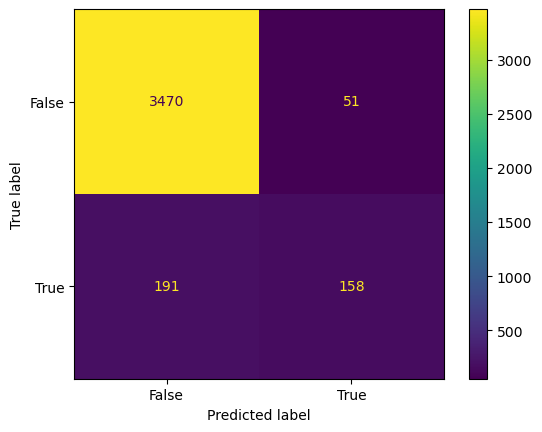

In [36]:
# Test model
t_gen = pre_generator.flow(
    X_pre.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

3000/3000 [==============================] - 39s 13ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
acc: 0.9723333333333334
2917
Thống kê bộ data predict:
Counter({0: 2925, 1: 75})
Thống kê bộ data actual:
Counter({0: 2926, 1: 74})
f1_score: 0.44295302013422816
Confusion Matrix:


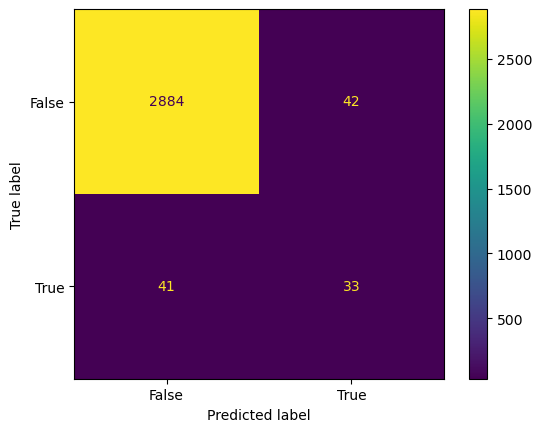

In [38]:
# Test model
t_gen = X_generator.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [31]:
model.save('model_20230922_over_ver01_0.394')

INFO:tensorflow:Assets written to: model_20230922_over_ver01_0.394\assets


INFO:tensorflow:Assets written to: model_20230922_over_ver01_0.394\assets


In [ ]:
# Test model data real
df_pred_test_ac = df.iloc[:].reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

In [ ]:
t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()